## Dimensionality Reduction

For most machine learning algorithms, model performance improves when having more features introduced until having too many features may result in worse model performance when <b>number of features is larger than number of observations</b>. This phenomenon is known as <b>curse of dimensionality</b>.

Dimensionality reduction is a feature selection technique that reduces the number of dimensions in the dataset without losing significant information of the original dataset.

To overcome the curse of dimensionality, there are two main approaches:
1. <b>Projection</b>: Mapping higher dimensional space to lower dimensional space perpendicularly


2. <b>Manifold Learning</b>: Mapping higher dimensional space to lower dimensional space using non-linear transformation
- Manifold refers to any 2-D shape that can be transformed to fit in higher-dimensional space by twisting or bending it
- Manifold learning assumes that real-world high dimensional datasets lie close to much lower dimensional manifold.

The following learning algorithms are the most popular ones used for dimensionality reduction:
1. PCA (Principal Component Analysis)
2. LLE (Locally Linear Embedding)

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from transformers import ScalingTransformer, OutlierCapTransformer

More details related to Exploratory Data Analysis for classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Classification.ipynb

## PCA (Principal Component Analysis)

Principal components analysis (PCA) is the most popular unsupervised method used for dimensionality reduction. 

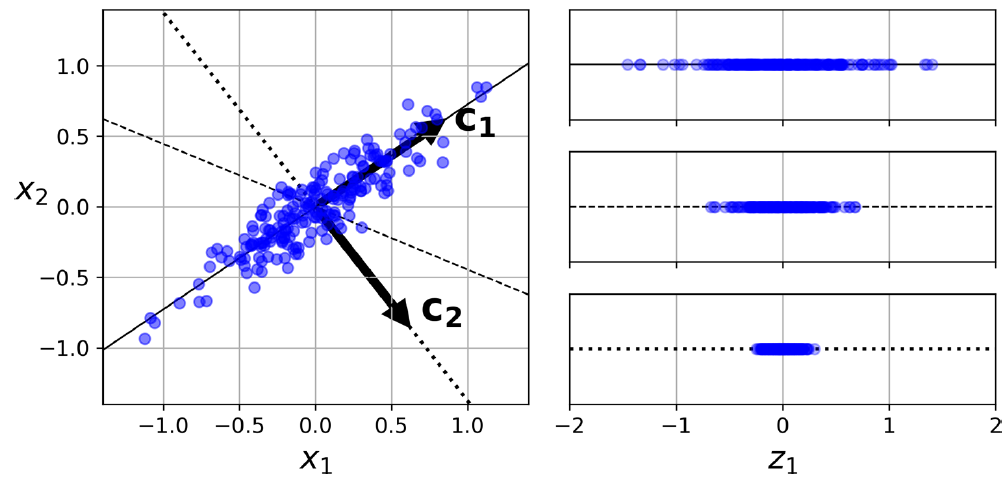

Principal components are derived features in the form of linear combination of original features, which the first principal component explains the maximum variance of the data and so on.

<b>Assumption of PCA</b>: Mean of all features is zero and standard deviation of all features is one (Centered around origin)

<b>Steps involved in PCA</b>:

1. Compute average of magnitude of all points.

2. Perform parallel translation of all points, such that the average point is on the origin

3. Identify best fit line that minimizes distance from individual data points and maximizes distance from origin, which is the <b>first principal component</b>

4. Second principal component line is simply orthogonal (perpendicular) to first principal component line and its location is determined by the maximum of <b>explained variance ratio</b>

<b>Advantages of PCA:</b>
1. Removes correlated features
2. Reduce model training time
3. Reduce risk of model overfitting
4. Provides better visualizations for lower dimensional data
5. Ability to handle noise

<b>Disadvantages of PCA:</b>
1. Principal components are less interpretable
2. Information loss if explained variance ratio threshold is not properly set

<b>Overall time complexity of PCA: O(n × p^2) + O(p^3)</b>
- n: Number of training samples
- p: Number of dimensions

Mathematically, principal components are determined by using <b>Singular Value Decomposition (SVD)</b> technique, which decomposes training set X into three different matrices as follows:

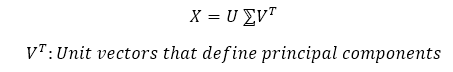

<b>Explained variance ratio</b> measures the amount of variance that each principal component is able to explain.

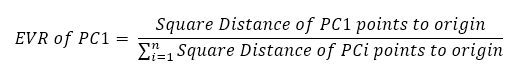

<b>Note that PCA is mostly suitable for continuous variables only after feature scaling, because PCA is designed to minimize variance which is not meaningful for binary data.</b>

Other versions of PCA in sklearn:
1. <b>Randomized PCA</b>: Stochastic algorithm that approximates the first d principal components specified.
2. <b>Kernel PCA</b>: Similar to SVM, it uses kernel trick for performing PCA algorithm
3. <b>Incremental PCA</b>: Used for very large datasets, which can be split into mini batches for online training.

In [2]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [3]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print('Total variance explained:',np.sum(search.best_estimator_.steps[-2][1].explained_variance_ratio_))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - LGBMClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9567531441087326
Best hyperparameters for fold 1: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.00017475110233000063), ('classification__learning_rate', 0.0744326469831664), ('classification__max_depth', 10), ('classification__min_child_samples', 25), ('classification__min_split_gain', 0.25737531692816096), ('classification__num_leaves', 2765), ('classification__reg_alpha', 0.21599770116945013), ('classification__reg_lambda', 5.243480849959898), ('classification__subsample', 0.7393830886829625), ('classification__subsample_freq', 9), ('pca__n_components', 12)])
Test F1 score for fold 1: 1.0
Total variance explained: 0.9918298713487309



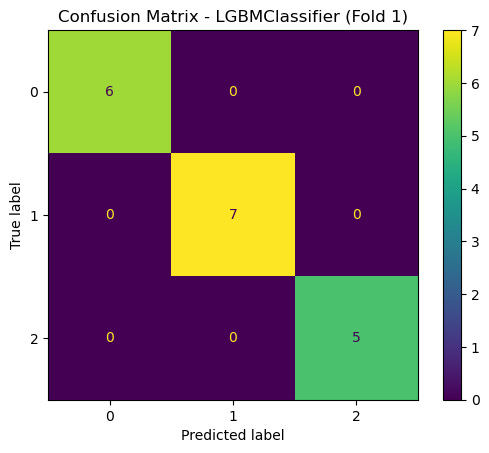


Validation F1 score for fold 2: 0.9456136889538425
Best hyperparameters for fold 2: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.041064184052070095), ('classification__learning_rate', 0.023299048982169498), ('classification__max_depth', 10), ('classification__min_child_samples', 25), ('classification__min_split_gain', 0.46736600067693834), ('classification__num_leaves', 835), ('classification__reg_alpha', 3.823998108551078), ('classification__reg_lambda', 1.5438565811486158), ('classification__subsample', 0.8304771481370851), ('classification__subsample_freq', 3), ('pca__n_components', 5)])
Test F1 score for fold 2: 1.0
Total variance explained: 0.8029304052316374



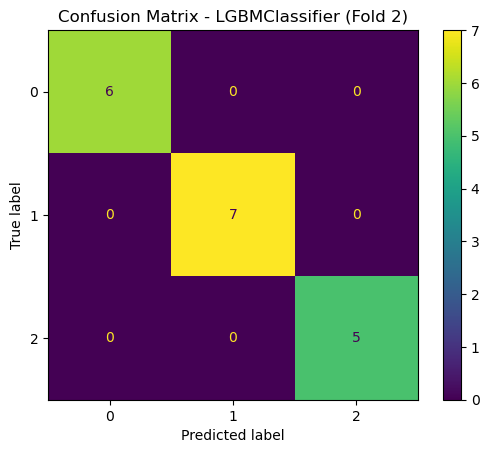


Validation F1 score for fold 3: 0.9503794953950464
Best hyperparameters for fold 3: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.9083829586038125), ('classification__learning_rate', 0.04259977456984563), ('classification__max_depth', 3), ('classification__min_child_samples', 57), ('classification__min_split_gain', 1.7310116811865943), ('classification__num_leaves', 267), ('classification__reg_alpha', 0.26502774133637963), ('classification__reg_lambda', 0.20571452156503597), ('classification__subsample', 0.9247070575618298), ('classification__subsample_freq', 9), ('pca__n_components', 7)])
Test F1 score for fold 3: 0.9487179487179486
Total variance explained: 0.8967499835180065



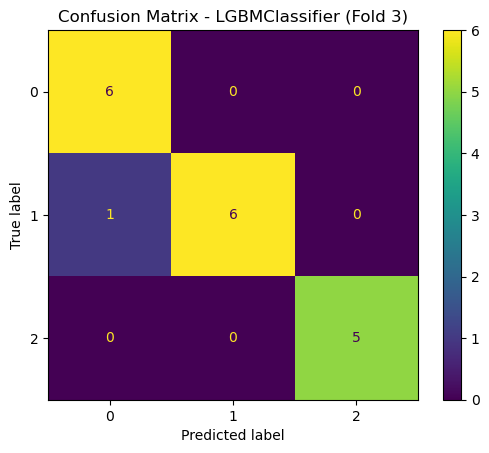


Validation F1 score for fold 4: 0.9571378314464418
Best hyperparameters for fold 4: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.4800442781687706), ('classification__learning_rate', 0.01655447375683829), ('classification__max_depth', 10), ('classification__min_child_samples', 42), ('classification__min_split_gain', 1.7217651194761894), ('classification__num_leaves', 1264), ('classification__reg_alpha', 0.959753879653723), ('classification__reg_lambda', 0.1108353756362349), ('classification__subsample', 0.739468711923378), ('classification__subsample_freq', 3), ('pca__n_components', 9)])
Test F1 score for fold 4: 0.9487179487179486
Total variance explained: 0.9418694366529725



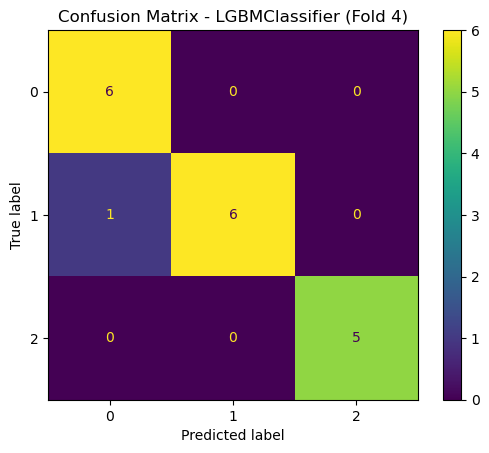


Validation F1 score for fold 5: 0.9257766382988262
Best hyperparameters for fold 5: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.000729712581972575), ('classification__learning_rate', 0.020330606624459187), ('classification__max_depth', 9), ('classification__min_child_samples', 29), ('classification__min_split_gain', 7.208768735476719), ('classification__num_leaves', 845), ('classification__reg_alpha', 0.1219849132641487), ('classification__reg_lambda', 16.630639011208263), ('classification__subsample', 0.9237379077507178), ('classification__subsample_freq', 5), ('pca__n_components', 6)])
Test F1 score for fold 5: 0.8851851851851852
Total variance explained: 0.8533000762056697



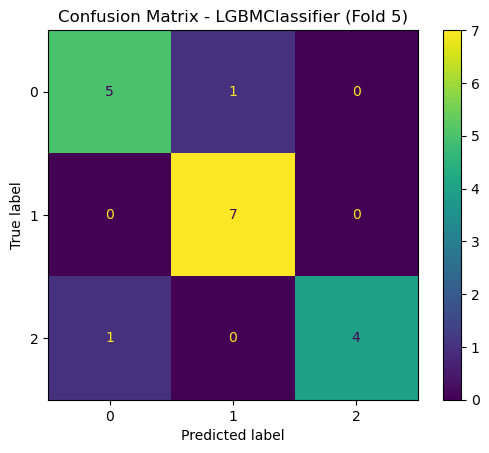


Validation F1 score for fold 6: 0.9326549546457829
Best hyperparameters for fold 6: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.009048500547981037), ('classification__learning_rate', 0.014119732105033539), ('classification__max_depth', 8), ('classification__min_child_samples', 12), ('classification__min_split_gain', 0.1997168077169845), ('classification__num_leaves', 3053), ('classification__reg_alpha', 0.40938009876058784), ('classification__reg_lambda', 0.3031683673698383), ('classification__subsample', 0.6408268550068841), ('classification__subsample_freq', 2), ('pca__n_components', 10)])
Test F1 score for fold 6: 1.0
Total variance explained: 0.9635485926875128



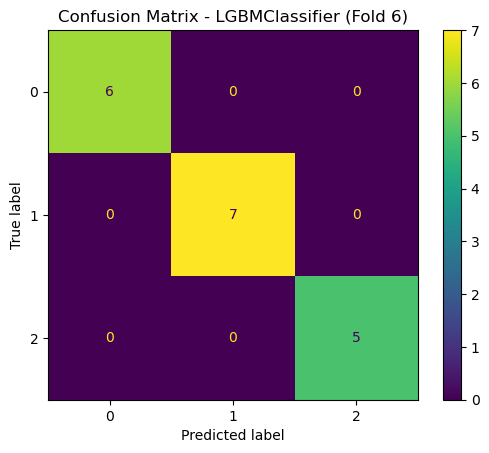


Validation F1 score for fold 7: 0.9209074665664605
Best hyperparameters for fold 7: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.0006373491843989574), ('classification__learning_rate', 0.06382860998804585), ('classification__max_depth', 9), ('classification__min_child_samples', 51), ('classification__min_split_gain', 0.2739464880805797), ('classification__num_leaves', 1100), ('classification__reg_alpha', 0.95564539583377), ('classification__reg_lambda', 0.20638903942123651), ('classification__subsample', 0.9237755664681384), ('classification__subsample_freq', 9), ('pca__n_components', 8)])
Test F1 score for fold 7: 0.8374727668845315
Total variance explained: 0.9207248757833398



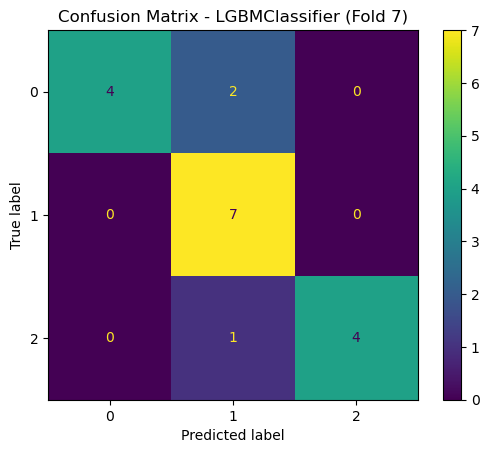


Validation F1 score for fold 8: 0.9378570583705679
Best hyperparameters for fold 8: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.009810202006478719), ('classification__learning_rate', 0.011636591140076218), ('classification__max_depth', 8), ('classification__min_child_samples', 34), ('classification__min_split_gain', 2.5611412788322547), ('classification__num_leaves', 1623), ('classification__reg_alpha', 0.39934005200519707), ('classification__reg_lambda', 0.11449650270500433), ('classification__subsample', 0.7234353761444013), ('classification__subsample_freq', 1), ('pca__n_components', 3)])
Test F1 score for fold 8: 0.8424242424242424
Total variance explained: 0.6715734054362147



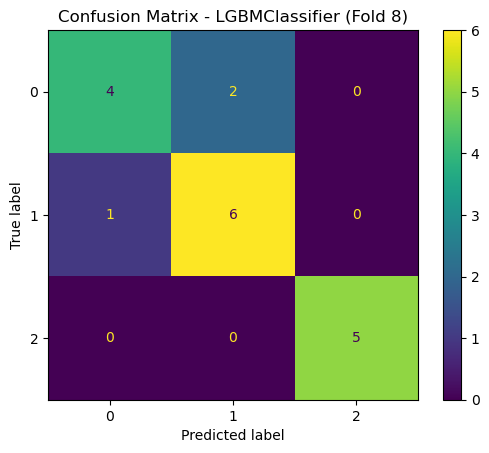


Validation F1 score for fold 9: 0.9455917302362316
Best hyperparameters for fold 9: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.00010499409480397917), ('classification__learning_rate', 0.17113234832305063), ('classification__max_depth', 4), ('classification__min_child_samples', 9), ('classification__min_split_gain', 0.12007902961846134), ('classification__num_leaves', 1320), ('classification__reg_alpha', 2.5031957433245102), ('classification__reg_lambda', 1.2430754172525065), ('classification__subsample', 0.7442978041122432), ('classification__subsample_freq', 8), ('pca__n_components', 11)])
Test F1 score for fold 9: 1.0
Total variance explained: 0.9799832194751101



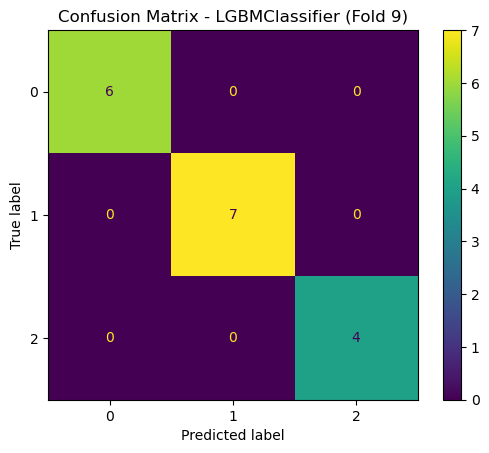


Validation F1 score for fold 10: 0.9654556458034718
Best hyperparameters for fold 10: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.04365539171190572), ('classification__learning_rate', 0.08186544063632024), ('classification__max_depth', 6), ('classification__min_child_samples', 19), ('classification__min_split_gain', 0.486789496704802), ('classification__num_leaves', 3342), ('classification__reg_alpha', 1.9577385215918945), ('classification__reg_lambda', 3.8258220877200255), ('classification__subsample', 0.7317809498688892), ('classification__subsample_freq', 8), ('pca__n_components', 7)])
Test F1 score for fold 10: 0.9407407407407408
Total variance explained: 0.8910976244671759



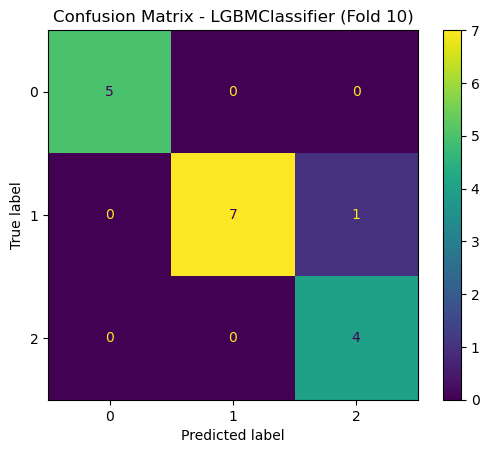


----------------------
Average validation F1 score: 0.9438127653825404
Average test F1 score: 0.9403258832670597


In [4]:
clf = LGBMClassifier(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('scaling',ScalingTransformer('Standard')))
pipeline.steps.append(('pca',PCA()))
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['pca__n_components'] = Integer(2,13)
search_space['classification__learning_rate'] = Real(0.01,0.3,'log-uniform')
search_space['classification__max_depth'] = Integer(3,12)
search_space['classification__num_leaves'] = Integer(8,4096)
search_space['classification__min_child_samples'] = Integer(5,100)
search_space['classification__drop_rate'] = Real(0.0001,1,'log-uniform')
search_space['classification__reg_lambda'] = Real(0.1,100,'log-uniform')
search_space['classification__reg_alpha'] = Real(0.1,100,'log-uniform')
search_space['classification__min_split_gain'] = Real(0.1,15,'log-uniform')        
search_space['classification__boosting_type'] = Categorical(['gbdt','dart'])
search_space['classification__subsample'] = Real(0.5,1,'log-uniform')
search_space['classification__subsample_freq'] = Integer(1,10)
nested_cv(X, y, pipeline, search_space)

## LLE (Locally Linear Embedding)

Locally Linear Embedding is a manifold learning technique, which does not rely on projections.

LLE method measures how each training instance linearly relates to its closest neighbors and then search for low dimensional representation, where these local relationships are best preserved.

<b>Assumption of LLE:</b> There is sufficient points, such that local neighborhood of samples around every point can be detected.

<b>Steps involved in LLE</b>:

<img src = "https://cs.nyu.edu/~roweis/lle/images/llef2med.gif" width="300">

1. Find K nearest neighbors for every data point

2. Reconstruct new data points as weighted aggregation of its neighbors, such that the following cost function is minimized by optimizing weights:
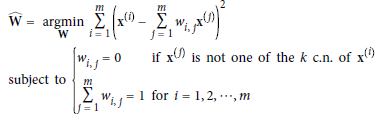


3. Map training instances into new dimensional space, such that the following cost function is minimized by optimizing positions of instances:
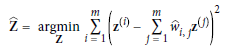

<b>Advantages of LLE:</b>
1. Able to detect non-linear relationships that kernel PCA could not detect
2. Better computational time than most dimensionality reduction algorithms

<b>Disadvantages of LLE:</b>
1. Not suitable for non-convex manifolds

<b>Overall time complexity of standard LLE: O(Dlog(k)Nlog(N)) + O(DNk^3) + O(dN^2)</b>
- N: number of training instances
- D: input dimension
- k: number of nearest neighbors
- d: output dimension
    
Other versions of LLE in sklearn:
1. <b>Modified LLE</b>: Uses multiple weight vectors in each neighborhood to address regularization problem
2. <b>Hessian LLE</b>: Uses hessian-based quadratic form at each neighborhood to recover locally linear structure.

In [5]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print('Reconstruction error:', search.best_estimator_.steps[-2][1].reconstruction_error_)
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - LGBMClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9500269837798442
Best hyperparameters for fold 1: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.010382081385669286), ('classification__learning_rate', 0.2710749360870339), ('classification__max_depth', 4), ('classification__min_child_samples', 41), ('classification__min_split_gain', 0.37280116463309504), ('classification__num_leaves', 697), ('classification__reg_alpha', 1.0661353956777586), ('classification__reg_lambda', 0.11911426464887676), ('classification__subsample', 0.896970893820312), ('classification__subsample_freq', 5), ('embedding__n_components', 5), ('embedding__reg', 0.0027869241586703955)])
Test F1 score for fold 1: 1.0
Reconstruction error: 0.008822939931301888



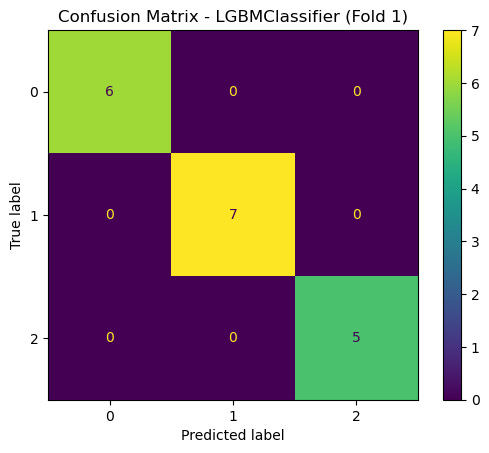


Validation F1 score for fold 2: 0.9650291330276074
Best hyperparameters for fold 2: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.6336789901932607), ('classification__learning_rate', 0.07642600865455733), ('classification__max_depth', 12), ('classification__min_child_samples', 10), ('classification__min_split_gain', 6.8079602560898484), ('classification__num_leaves', 284), ('classification__reg_alpha', 1.1244659987529046), ('classification__reg_lambda', 40.85764062276326), ('classification__subsample', 0.8805734015703087), ('classification__subsample_freq', 2), ('embedding__n_components', 8), ('embedding__reg', 0.0037387623942026285)])
Test F1 score for fold 2: 1.0
Reconstruction error: 0.04157920314415414



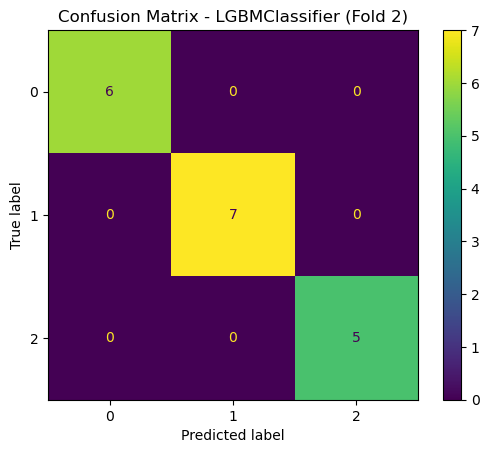


Validation F1 score for fold 3: 0.9513451224313162
Best hyperparameters for fold 3: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.1451733100165711), ('classification__learning_rate', 0.1526329388360585), ('classification__max_depth', 5), ('classification__min_child_samples', 40), ('classification__min_split_gain', 0.17284795418553967), ('classification__num_leaves', 205), ('classification__reg_alpha', 0.18054570518625665), ('classification__reg_lambda', 63.5532018355488), ('classification__subsample', 0.6929203259392847), ('classification__subsample_freq', 8), ('embedding__n_components', 4), ('embedding__reg', 0.02747081403476666)])
Test F1 score for fold 3: 0.9487179487179486
Reconstruction error: 0.023496752248392025



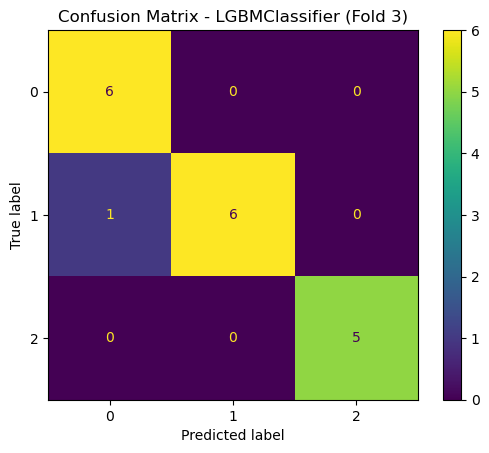


Validation F1 score for fold 4: 0.9639530003008264
Best hyperparameters for fold 4: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.00015092022483595077), ('classification__learning_rate', 0.02823870821030033), ('classification__max_depth', 8), ('classification__min_child_samples', 14), ('classification__min_split_gain', 0.9786497056034353), ('classification__num_leaves', 2594), ('classification__reg_alpha', 2.7389638432518257), ('classification__reg_lambda', 18.392662134600993), ('classification__subsample', 0.512764935734619), ('classification__subsample_freq', 2), ('embedding__n_components', 6), ('embedding__reg', 0.013410974042292235)])
Test F1 score for fold 4: 0.8243589743589742
Reconstruction error: 0.04182446469456855



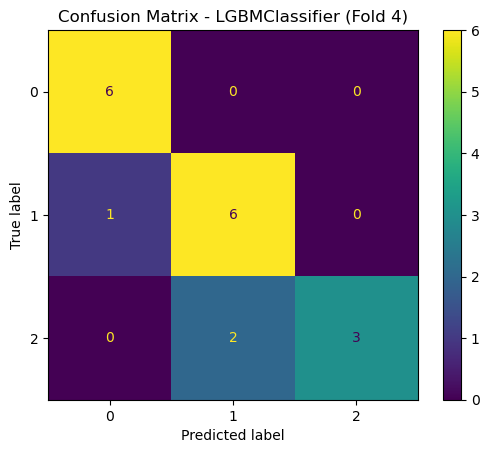


Validation F1 score for fold 5: 0.9702302682917392
Best hyperparameters for fold 5: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.019605882096174053), ('classification__learning_rate', 0.02713997142743891), ('classification__max_depth', 10), ('classification__min_child_samples', 27), ('classification__min_split_gain', 0.14925077234394357), ('classification__num_leaves', 3300), ('classification__reg_alpha', 7.857107564733335), ('classification__reg_lambda', 1.497977259863941), ('classification__subsample', 0.5568280713914396), ('classification__subsample_freq', 2), ('embedding__n_components', 7), ('embedding__reg', 0.0017752852831946218)])
Test F1 score for fold 5: 0.9407407407407408
Reconstruction error: 0.025080390315674404



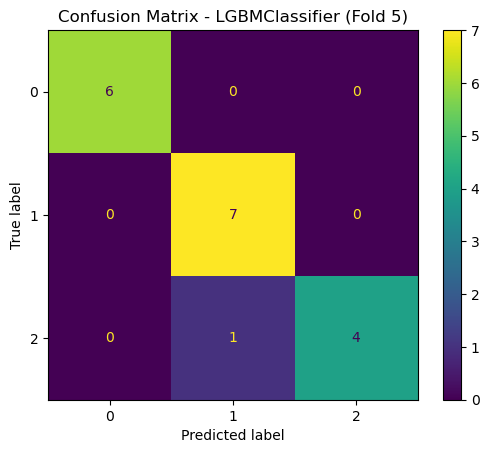


Validation F1 score for fold 6: 0.9451819447608921
Best hyperparameters for fold 6: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.000868037434351727), ('classification__learning_rate', 0.16029211013985498), ('classification__max_depth', 9), ('classification__min_child_samples', 36), ('classification__min_split_gain', 6.076976426224415), ('classification__num_leaves', 1695), ('classification__reg_alpha', 0.26635921766026543), ('classification__reg_lambda', 0.3496261341126922), ('classification__subsample', 0.7346977735065833), ('classification__subsample_freq', 5), ('embedding__n_components', 13), ('embedding__reg', 0.00994402301514822)])
Test F1 score for fold 6: 1.0
Reconstruction error: 0.21140863525575693



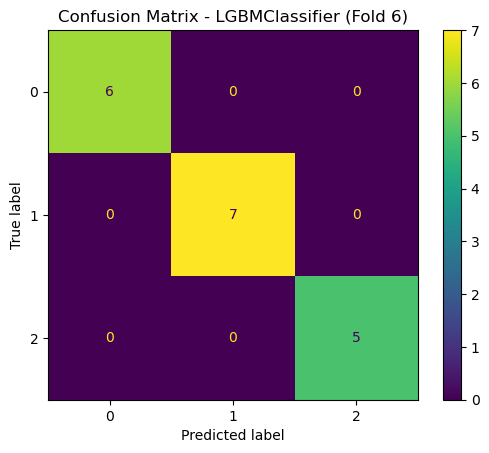


Validation F1 score for fold 7: 0.9304641655488337
Best hyperparameters for fold 7: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.0014295289508665168), ('classification__learning_rate', 0.05144268661058957), ('classification__max_depth', 9), ('classification__min_child_samples', 24), ('classification__min_split_gain', 6.3726167300460395), ('classification__num_leaves', 2786), ('classification__reg_alpha', 0.12263060315933172), ('classification__reg_lambda', 2.4711351327405033), ('classification__subsample', 0.5851224909635746), ('classification__subsample_freq', 10), ('embedding__n_components', 6), ('embedding__reg', 0.007083369656715375)])
Test F1 score for fold 7: 0.9474747474747475
Reconstruction error: 0.02294262816914565



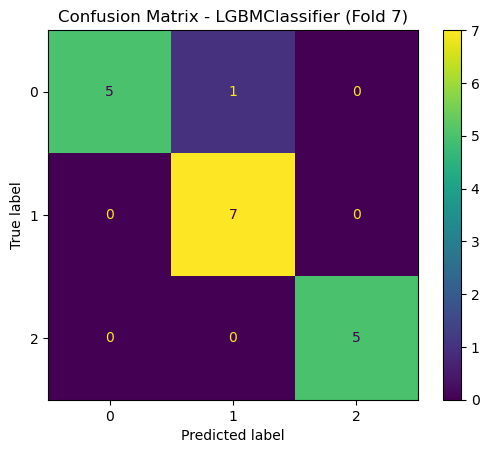


Validation F1 score for fold 8: 0.9816799325205123
Best hyperparameters for fold 8: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.001789734659764233), ('classification__learning_rate', 0.011596034615897302), ('classification__max_depth', 5), ('classification__min_child_samples', 12), ('classification__min_split_gain', 0.8740137593456794), ('classification__num_leaves', 3480), ('classification__reg_alpha', 0.3636098380503643), ('classification__reg_lambda', 0.7946861818471022), ('classification__subsample', 0.9383365135551117), ('classification__subsample_freq', 6), ('embedding__n_components', 6), ('embedding__reg', 0.00891882425807145)])
Test F1 score for fold 8: 0.9440559440559441
Reconstruction error: 0.018935094609173503



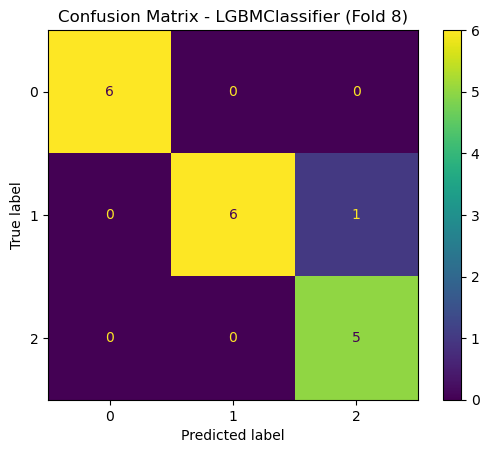


Validation F1 score for fold 9: 0.9403775864782729
Best hyperparameters for fold 9: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.0004629099576403089), ('classification__learning_rate', 0.054244649987390446), ('classification__max_depth', 11), ('classification__min_child_samples', 58), ('classification__min_split_gain', 2.6583234065898154), ('classification__num_leaves', 1500), ('classification__reg_alpha', 5.51590736882711), ('classification__reg_lambda', 23.437527653460315), ('classification__subsample', 0.9669613873850031), ('classification__subsample_freq', 2), ('embedding__n_components', 13), ('embedding__reg', 0.0239035436131617)])
Test F1 score for fold 9: 1.0
Reconstruction error: 0.3395353315382258



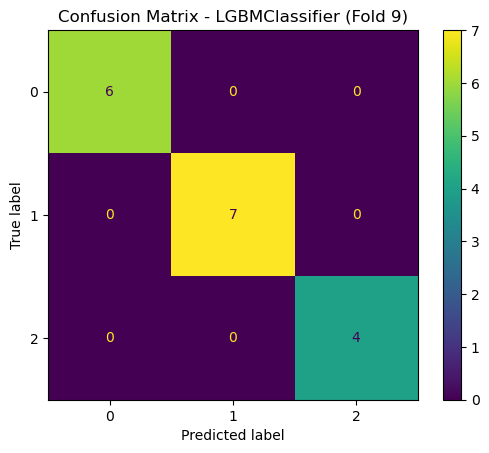


Validation F1 score for fold 10: 0.9650115869383603
Best hyperparameters for fold 10: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.00031475446748917816), ('classification__learning_rate', 0.08735777290829974), ('classification__max_depth', 11), ('classification__min_child_samples', 39), ('classification__min_split_gain', 1.968326638238592), ('classification__num_leaves', 2710), ('classification__reg_alpha', 0.1548614609635964), ('classification__reg_lambda', 48.69453418264773), ('classification__subsample', 0.9298431005997168), ('classification__subsample_freq', 6), ('embedding__n_components', 3), ('embedding__reg', 0.0011637318625918307)])
Test F1 score for fold 10: 0.9327731092436974
Reconstruction error: 0.002215234093465927



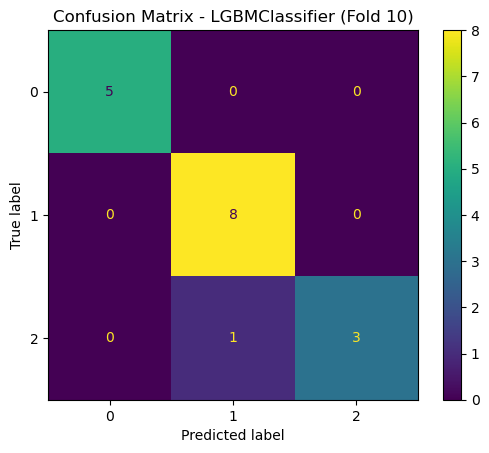


----------------------
Average validation F1 score: 0.9563299724078205
Average test F1 score: 0.9538121464592052


In [6]:
clf = LGBMClassifier(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('scaling',ScalingTransformer('Standard')))
pipeline.steps.append(('embedding',LocallyLinearEmbedding(random_state=120,n_jobs=-1)))
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['embedding__n_components'] = Integer(2,13)
search_space['embedding__reg'] = Real(0.001,0.1,'log-uniform')
search_space['classification__learning_rate'] = Real(0.01,0.3,'log-uniform')
search_space['classification__max_depth'] = Integer(3,12)
search_space['classification__num_leaves'] = Integer(8,4096)
search_space['classification__min_child_samples'] = Integer(5,100)
search_space['classification__drop_rate'] = Real(0.0001,1,'log-uniform')
search_space['classification__reg_lambda'] = Real(0.1,100,'log-uniform')
search_space['classification__reg_alpha'] = Real(0.1,100,'log-uniform')
search_space['classification__min_split_gain'] = Real(0.1,15,'log-uniform')        
search_space['classification__boosting_type'] = Categorical(['gbdt','dart'])
search_space['classification__subsample'] = Real(0.5,1,'log-uniform')
search_space['classification__subsample_freq'] = Integer(1,10)
nested_cv(X, y, pipeline, search_space)